# Algo - Using Options as a Future "Order Book"

## Fetch data

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Datetime'>

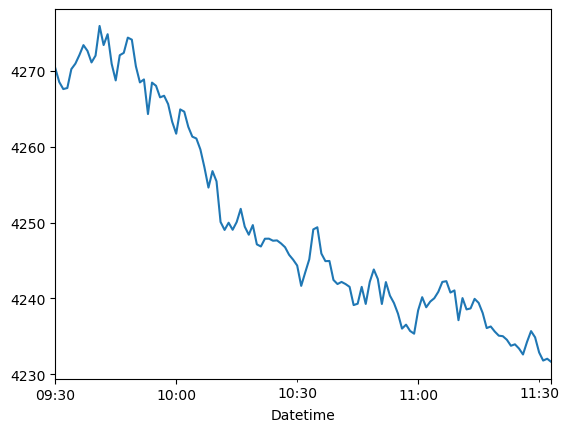

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

# get daily minute data
ticker = yf.Ticker('^SPX')
ticker_options = ticker.option_chain()
today_data = yf.download('^SPX', 
                       start=datetime.date.today().strftime("%Y-%m-%d"),  
                       interval = "1m")
today_data['Close'].plot()

In [18]:
try:
    close = today_data.between_time("11:30", "11:30")["Close"][-1]
except IndexError as e:
    print("Error: No data available at 11:30AM. Check day and time.")
else:
    print(f'Price at 11:30AM: {close}')

Price at 11:30AM: 4232.89013671875


## Data for Option Chain

In [19]:
ticker_options.puts['r_strike'] = ticker_options.puts['strike'].apply(lambda x: round(x/30)*30)
ticker_options.calls['r_strike'] = ticker_options.calls['strike'].apply(lambda x: round(x/30)*30) # 30 from analysis, moves after 11:30AM are around 15 points +- 1 std of 15. Essentially 1 bracket in Kalshi
ticker_options.puts.groupby('r_strike').sum('openInterest').reset_index()
ticker_options.calls.groupby('r_strike').sum('openInterest').reset_index()

,r_strike,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney
0,210,200.0,4163.72,4031.4,4032.40,0.0,0.0,2.0,549.0,19.093754,1
1,390,400.0,3880.40,3831.4,3832.40,0.0,0.0,8.0,83.0,14.593751,1
2,600,600.0,3672.56,3632.1,3633.10,0.0,0.0,2.0,34.0,13.564455,1
3,810,800.0,3653.30,0.0,0.00,0.0,0.0,1.0,0.0,0.000010,1
4,990,1000.0,3218.60,3248.6,3300.50,0.0,0.0,10.0,3716.0,17.490117,1
...,...,...,...,...,...,...,...,...,...,...,...
104,6000,6000.0,0.07,0.0,0.00,0.0,0.0,1.0,0.0,0.500005,0
105,6210,6200.0,0.07,0.0,0.05,0.0,0.0,0.0,1.0,2.046880,0
106,6390,6400.0,0.06,0.0,0.00,0.0,0.0,8.0,0.0,1.000005,0
107,6600,6600.0,0.05,0.0,0.00,0.0,0.0,1.0,0.0,0.500005,0


In [20]:
# sum open interest for calls above and below current price

sum_calls_below_threshold = round(((close+30)/30)*30)
sum_puts_above_threshold = round(((close-30)/30)*30)
OI_puts = ticker_options.puts[ticker_options.puts["r_strike"] > sum_puts_above_threshold].openInterest.sum()
OI_calls = ticker_options.calls[ticker_options.calls["r_strike"] < sum_calls_below_threshold].openInterest.sum()

print(f'Date: {datetime.date.today().strftime("%Y-%m-%d")}')
print()
print(f'OI puts: {OI_puts}')
print(f'OI calls: {OI_calls}')

brackets = np.linspace(2000, 6000, (4000//25)+1, dtype=int) #all kalshi brackets

if OI_puts > OI_calls:
    # buy bracket below
    print(f'Betting down, buying bracket ${brackets[abs(brackets - (close - 30)).argmin()]}-{brackets[abs(brackets - (close)).argmin()]}')
else:
    # buy bracket above
    print(f'Betting up, buying bracket ${brackets[abs(brackets - (close + 30)).argmin()]}-{brackets[abs(brackets - (close + 60)).argmin()]}')

Date: 2023-10-20

OI puts: 255245.0
OI calls: 40112.0
Betting down, buying bracket $4200-4225


## Backtesting

Note: Methods for a backtest is flawed since option data is not available by the minute or hour. 

In [76]:
print(f'<Down bracket | Price at 11:30 | Up bracket>')
print(f'<{brackets[abs(brackets - (close - 30)).argmin()]}-{brackets[abs(brackets - (close)).argmin()]} | {close:.2f} | {brackets[abs(brackets - (close + 30)).argmin()]}-{brackets[abs(brackets - (close + 60)).argmin()]}>')

<Down bracket | Price at 11:30 | Up bracket>
<4275-4300 | 4306.64 | 4325-4375>


In [63]:
#10/18 ended 4312, W (4342 - 30 = 4312 -> buy YES 4300-4325 OR 4325-4350 [12 is in between])
#10/19 ended 4277, W (<4275-4300 | 4306.64 | 4325-4375> predict down)
#10/20 ended 4224, W (4232.89 predict 4200-4225 down)
brackets

array([2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250,
       2275, 2300, 2325, 2350, 2375, 2400, 2425, 2450, 2475, 2500, 2525,
       2550, 2575, 2600, 2625, 2650, 2675, 2700, 2725, 2750, 2775, 2800,
       2825, 2850, 2875, 2900, 2925, 2950, 2975, 3000, 3025, 3050, 3075,
       3100, 3125, 3150, 3175, 3200, 3225, 3250, 3275, 3300, 3325, 3350,
       3375, 3400, 3425, 3450, 3475, 3500, 3525, 3550, 3575, 3600, 3625,
       3650, 3675, 3700, 3725, 3750, 3775, 3800, 3825, 3850, 3875, 3900,
       3925, 3950, 3975, 4000, 4025, 4050, 4075, 4100, 4125, 4150, 4175,
       4200, 4225, 4250, 4275, 4300, 4325, 4350, 4375, 4400, 4425, 4450,
       4475, 4500, 4525, 4550, 4575, 4600, 4625, 4650, 4675, 4700, 4725,
       4750, 4775, 4800, 4825, 4850, 4875, 4900, 4925, 4950, 4975, 5000,
       5025, 5050, 5075, 5100, 5125, 5150, 5175, 5200, 5225, 5250, 5275,
       5300, 5325, 5350, 5375, 5400, 5425, 5450, 5475, 5500, 5525, 5550,
       5575, 5600, 5625, 5650, 5675, 5700, 5725, 57